In [1]:
%load_ext autoreload
%autoreload 2

import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

import numpy as np
from neuromancer.psl.signals import step, sines, periodic, noise, walk
from neuromancer.psl.base import ODE_NonAutonomous as ODE
from neuromancer.psl.base import cast_backend
import inspect, sys
from neuromancer.psl import autonomous, nonautonomous, building_envelope, coupled_systems
from neuromancer.dynamics.ode import ODESystem
import torch.nn as nn

torch.manual_seed(0)

## Define class for simulating ground-truth 4th order synchronous machine model

In [2]:
# The class `Syn_Machine_Order_4` is added by Marie Meng Wu @ 2023-11-6
# class SwingEquation(ODE):
class Syn_Machine_Order_4(ODE):
    """
    `4th order synchronous machine model from PSAT user manual equations 15.15 and 15.16.
    States x = [delta, omega, eq', ed']
    inputs u = [pe, vq, vd]
    """
    @property
    def params(self):
        # Pm = 0.8
        # Pmax = 5.0
        # H = 500.
        # freq = 60.
        # ws = 2 * np.pi * freq
        variables = {'x0': [0.9449, 1, 0.7679, 0.6242]}
        constants = {'ts': 0.01}
        parameters = {# 'Pm': Pm,  # Mechanical power
                      # 'Pmax': Pmax,  # Maximum electrical output
                      # 'H': H,  # Inertia constant
                      # 'D': 5.,  # Damping coefficient
                      # 'freq': freq,  # Base frequency
                      # 'ws': ws,  # Base angular speed
                      # 'M': 2 * H / ws  # scaled inertia constant
                      'D': 0,
                      'M': 6.02,
                      'xd': 1.3125,
                      'xdp': 0.1813,
                      'Tdop': 5.89,
                      'xq': 1.2578,
                      'xqp': 0.25,
                      'Tqop': 0.6,
                      #'Kw': 0,
                      #'Kp': 0,
                      'ra': 0,
                      'xl': 0,
                      'omega_b': 2 * np.pi * 60,

                      'pm': 0.85,
                      'vf_star': 1.403
                       }
        meta = {}
        return variables, constants, parameters, meta

    @cast_backend
    def get_U(self, nsim, signal=None, **signal_kwargs):

        # umax = 1.02
        # umin = 0.98
        umax = 1.5
        umin = 0.5

        if signal is not None:
            return super().get_U(nsim=nsim, signal=signal, **signal_kwargs)
        """
        Noisy mechanical power with constant Pmax)
        """
        u = step(nsim=nsim, d=3,  min=[0.85 * umin, 0.6661 * umin, 0.7791 * umin], max=[0.85 * umax, 0.6661 * umax, 0.7791 * umax],
                 randsteps=int(np.ceil(nsim / 200)),
                 rng=self.rng)
        return u

    @cast_backend
    def equations(self, t, x, u):
        # delta = x[0]
        # domega = x[1]
        # Pm = u[0]
        # Pmax = self.Pmax

        # States x = [delta, omega, eq', ed']
        delta = x[0]
        omega = x[1]
        eqp = x[2]
        edp = x[3]

        # inputs u = [pe, vq, vd]
        pe = u[0]
        vq = u[1]
        vd = u[2]

        # dx_dt = [self.ws * domega,
        #          (Pm - Pmax * np.sin(delta) - self.D * domega) / self.M]

        #iq = ((4*(eqp*self.ra - edp*self.xdp + edp*self.xl - self.ra*vq + vd*self.xdp - vd*self.xl))/(self.xdp - self.xl - 4*self.xdp*self.xl + 4*self.ra**2 + 4*self.xl**2))
        #id = ((eqp - vq + 4*edp*self.ra - 4*eqp*self.xl - 4*self.ra*vd + 4*vq*self.xl)/(self.xdp - self.xl - 4*self.xdp*self.xl + 4*self.ra**2 + 4*self.xl**2))

        # fs = eqp

        dx_dt = [self.omega_b * (omega - 1),
                 (self.pm - pe - self.D * (omega - 1)) / self.M,
                # (-fs - (self.xd - self.xdp) * id + self.vf_star) / self.Tdop,
                # (-edp + (self.xq - self.xqp) * iq) / self.Tqop]
                (-eqp - (self.xd - self.xdp) * ((eqp - vq + 4*edp*self.ra - 4*eqp*self.xl - 4*self.ra*vd + 4*vq*self.xl)/(self.xdp - self.xl - 4*self.xdp*self.xl + 4*self.ra**2 + 4*self.xl**2)) + self.vf_star) / self.Tdop,
                (-edp + (self.xq - self.xqp) * ((4*(eqp*self.ra - edp*self.xdp + edp*self.xl - self.ra*vq + vd*self.xdp - vd*self.xl))/(self.xdp - self.xl - 4*self.xdp*self.xl + 4*self.ra**2 + 4*self.xl**2))) / self.Tqop]
        
        return dx_dt

## Generate trajectories from ODE system 

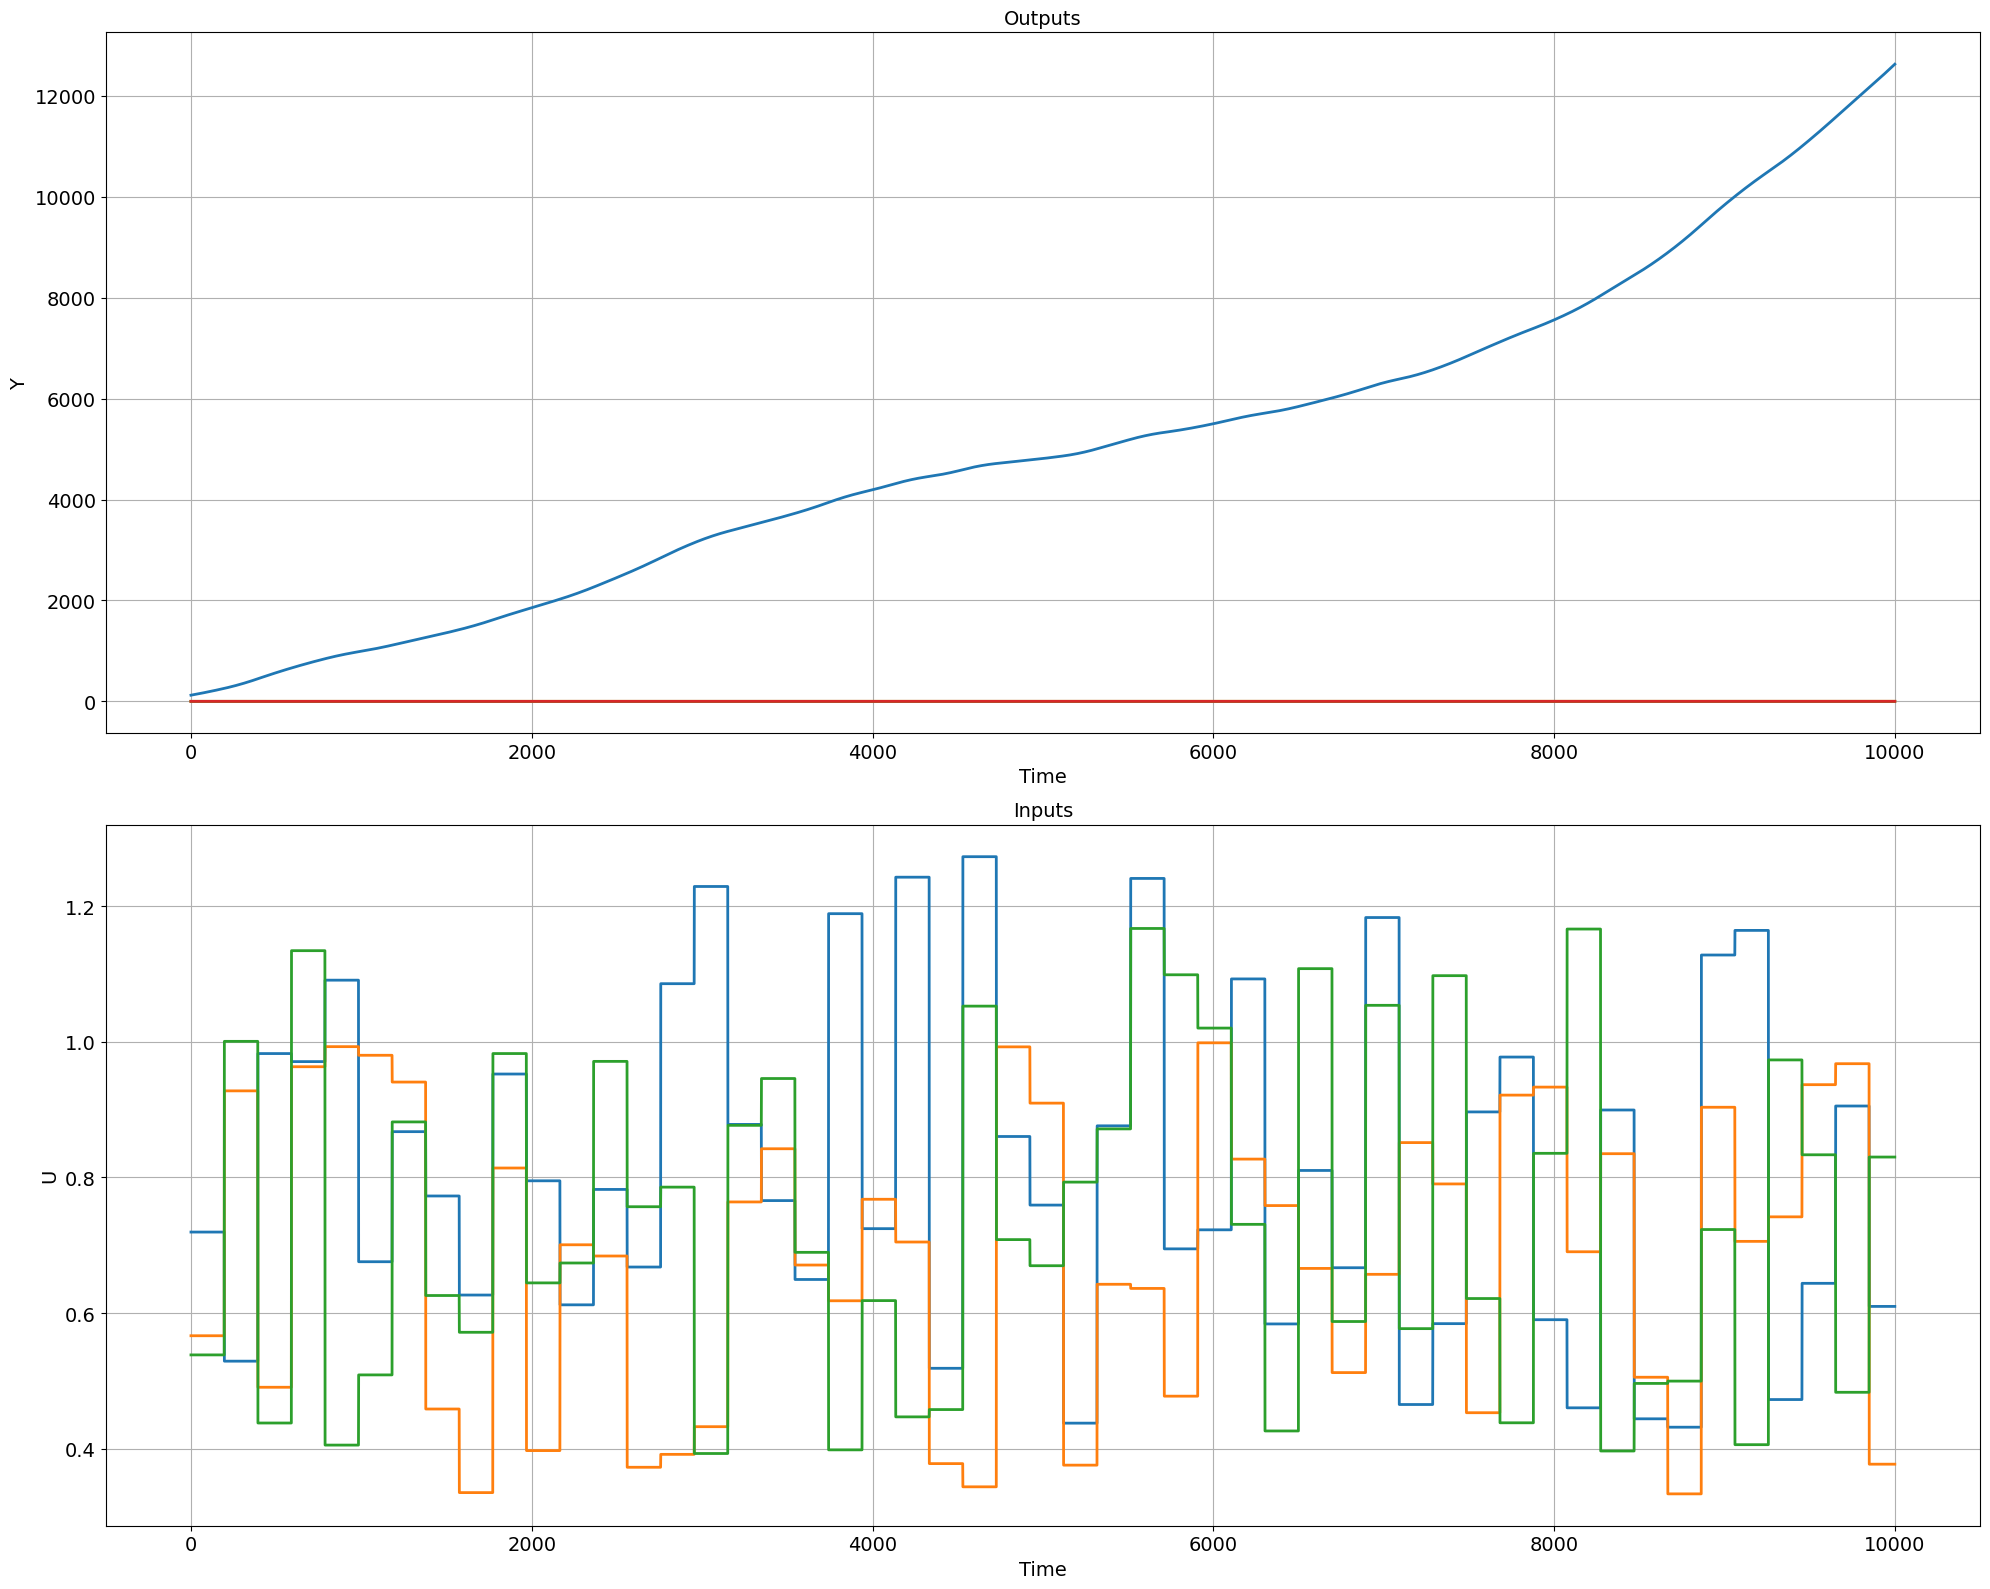

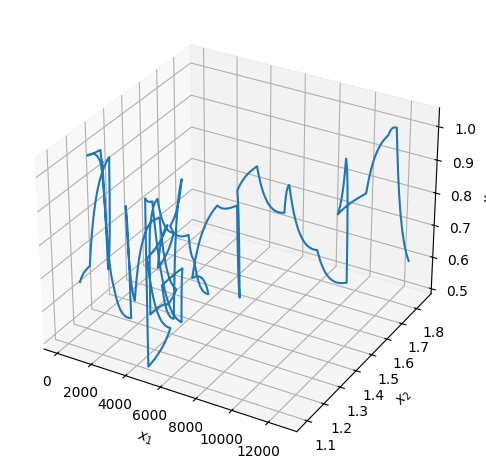

In [3]:
# %%  ground truth system
# system_name = 'SwingEquation'
# system_name = 'Syn_Machine_Order_4'
# system = psl.systems[system_name]
modelSystem = Syn_Machine_Order_4()
# modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1000*10, ts=ts)
plot.pltOL(Y=raw['Y'], U=raw['U'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

In [4]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    # for systems with out of scale variables it is important to normalize the data before training
    mean_x = modelSystem.stats['X']['mean']
    std_x = modelSystem.stats['X']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    def normalize(x, mean, std):
        return (x - mean) / std

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :],
                 'U': testU}

    return train_loader, dev_loader, test_data

In [5]:
nsim = 2000*5   # number of simulation steps in the dataset
nsteps = 10*2   # number of prediction horizon steps in the loss function
bs = 100*2      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## ODE system model in Neuromancer

Here we construct a continuous-time ODE model  $\dot{x} = f_{\theta}(x,u)$ with trainable parameters $\theta$.

In [6]:
# define ODE system in Neuromancer
class Syn_Machine_Order_4_Param(ODESystem):
    def __init__(self, insize=nx+nu, outsize=nx):
        super().__init__(insize=insize, outsize=outsize)
        self.D = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
        self.M_inv = nn.Parameter(torch.tensor([1/6.02]), requires_grad=True)
        self.xd = nn.Parameter(torch.tensor([1.3125]), requires_grad=True)
        self.xdp = nn.Parameter(torch.tensor([0.1813]), requires_grad=True)
        self.Tdop_inv = nn.Parameter(torch.tensor([1/5.89]), requires_grad=True)
        self.xq = nn.Parameter(torch.tensor([1.2578]), requires_grad=True)
        self.xqp = nn.Parameter(torch.tensor([0.25]), requires_grad=True)
        self.Tqop_inv = nn.Parameter(torch.tensor([1/0.6]), requires_grad=True)
        #self.Kw = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        #self.Kp = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.ra = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
        self.xl = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
        # self.omega_b = nn.Parameter(torch.tensor([0]), requires_grad=True)
        # self.pm = nn.Parameter(torch.tensor([0.85]), requires_grad=True)
        # self.vf_star = nn.Parameter(torch.tensor([1.403]), requires_grad=True)
    
    def ode_equations(self, x, u):
        omega_b = 2 * np.pi * 60
        pm = 0.85
        vf_star = 1.403
        
        delta = x[:, [0]]
        omega = x[:, [1]]
        eqp = x[:, [2]]
        edp = x[:, [3]]

        pe = u[:, [0]]
        vq = u[:, [1]]
        vd = u[:, [2]]

        dx1 = omega_b * (omega - 1)
        dx2 = (pm - pe - self.D * (omega - 1)) * self.M_inv
        dx3 = (-eqp - (self.xd - self.xdp) * ((eqp - vq + 4*edp*self.ra - 4*eqp*self.xl - 4*self.ra*vd + 4*vq*self.xl)/(self.xdp - self.xl - 4*self.xdp*self.xl + 4*self.ra**2 + 4*self.xl**2)) + vf_star) * self.Tdop_inv
        dx4 = (-edp + (self.xq - self.xqp) * ((4*(eqp*self.ra - edp*self.xdp + edp*self.xl - self.ra*vq + vd*self.xdp - vd*self.xl))/(self.xdp - self.xl - 4*self.xdp*self.xl + 4*self.ra**2 + 4*self.xl**2))) * self.Tqop_inv
        
        return torch.cat([dx1, dx2, dx3, dx4], dim=-1)

Here we construct an open-loop system composed of the ODE models solved with ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods):  
$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$ 

For training we need to obtain accurate reverse-mode gradients of the integrated ODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method).

Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class. In this example we will use BPTT algorithm through unrolled RK4 solver.

In [7]:
# instantiate ODE system
syn_mach_4 = Syn_Machine_Order_4_Param()
# use ODE solver to discretize the ODE with a given timestep h
fxRK4 = integrators.RK4(syn_mach_4, h=ts)
# create symbolic system model in Neuromancer
dynamics_model = System([Node(fxRK4, ['xn', 'U'], ['xn'])], nsteps=nsteps)

## NODE system model in Neuromancer

Here we construct a non-autonomous NODE model  $\dot{x} = f_{\theta}(x, u)$ with trainable parameters $\theta$.

In [28]:
# define neural network of the NODE
fx = blocks.MLP(nx+nu, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[80, 80, 80])

Next we need to solve the continuous-time NODE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  
$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$ 

For training we need to obtain accurate reverse-mode gradients of the integrated ODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method).

Schematics illustrating the adjoing method used in the [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) paper:
<img src="../figs/NODE_backprop.png" width="500">  

Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class. In this example we will use BPTT algorithm through unrolled RK4 solver.

In [29]:
# integrate NODE with adjoint-based solver
fxRK4 = integrators.RK4(fx, h=ts)

Next we construct an open-loop system composed of a smbolic NODE model

In [30]:
# create symbolic system model in Neuromancer
model = Node(fxRK4, ['xn', 'U'], ['xn'], name='NODE')
dynamics_model = System([model], name='system', nsteps=nsteps)

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 
**Finite difference loss:**  
$$\ell_{dx} =  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2$$
where $\Delta x^i_k = x^i_{k+1} - x^i_k$

In [8]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# define finite difference variables
# xFD = (x[:, 1:, :] - x[:, :-1, :])
# xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# trajectory tracking loss
reference_loss = 5.*(xhat == x)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# finite difference loss - i.e., fitting first derivatives
# fd_loss = 2.0*((xFD == xhatFD)^2)
# fd_loss.name = 'FD_loss'

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta}(x^i_k, u^i_k)) \\
\end{align}
$$  

In [14]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [16]:
optimizer = torch.optim.Adam(problem.parameters(),
                             lr=0.003)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=100*10,
    warmup=100*10,
    epochs=1000*10,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 10


In [17]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 116705.55469	dev_loss: 55230.06250	eltime:  5.06975
epoch: 1	train_loss: 107089.32812	dev_loss: 63186.21094	eltime:  5.41855
epoch: 2	train_loss: 97975.96094	dev_loss: 65099.50391	eltime:  5.75386
epoch: 3	train_loss: 97984.38281	dev_loss: 58840.92969	eltime:  6.08146
epoch: 4	train_loss: 83593.28125	dev_loss: 70051.29688	eltime:  6.45268
epoch: 5	train_loss: 96326.46875	dev_loss: 56460.05859	eltime:  7.04761
epoch: 6	train_loss: 111857.82812	dev_loss: 64203.03516	eltime:  7.39537
epoch: 7	train_loss: 88091.21094	dev_loss: 71352.62500	eltime:  7.77648
epoch: 8	train_loss: 100230.25781	dev_loss: 57666.61328	eltime:  8.10604
epoch: 9	train_loss: 99558.34375	dev_loss: 63667.87109	eltime:  8.44807
epoch: 10	train_loss: 96223.50781	dev_loss: 69624.25000	eltime:  8.88430
epoch: 11	train_loss: 83319.28906	dev_loss: 56397.86328	eltime:  9.30813
epoch: 12	train_loss: 89153.61719	dev_loss: 61966.23047	eltime:  9.64688
epoch: 13	train_loss: 97864.76562	dev_loss: 73683.17188	e

<All keys matched successfully>

## Parameter estimation results

In [18]:
# trained parameters
print('D = '+str(syn_mach_4.D.item()))
print('M = '+str(1/syn_mach_4.M_inv.item()))
print('xd = '+str(syn_mach_4.xd.item()))
print('xdp = '+str(syn_mach_4.xdp.item()))
print('Tdop = '+str(1/syn_mach_4.Tdop_inv.item()))
print('xq = '+str(syn_mach_4.xq.item()))
print('xqp = '+str(syn_mach_4.xqp.item()))
print('Tqop = '+str(1/syn_mach_4.Tqop_inv.item()))
#print('Kw = '+str(syn_mach_4.Kw.item()))
#print('Kp = '+str(syn_mach_4.Kp.item()))
print('ra = '+str(syn_mach_4.ra.item()))
print('xl = '+str(syn_mach_4.xl.item()))
#print('pm = '+str(syn_mach_4.pm.item()))
#print('vf_star = '+str(syn_mach_4.vf_star.item()))

D = 16.540735244750977
M = 0.05932158226942209
xd = 4.016178131103516
xdp = 0.26354607939720154
Tdop = 153.4900433699337
xq = 2.68715238571167
xqp = -1.1793632507324219
Tqop = 40.75524432418883
ra = 0.00023217458510771394
xl = 0.23935645818710327


In [19]:
syn_mach_4.xdp - syn_mach_4.xl - 4*syn_mach_4.xdp*syn_mach_4.xl + 4*syn_mach_4.ra**2 + 4*syn_mach_4.xl**2

tensor([0.0010], grad_fn=<AddBackward0>)

In [20]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [21]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

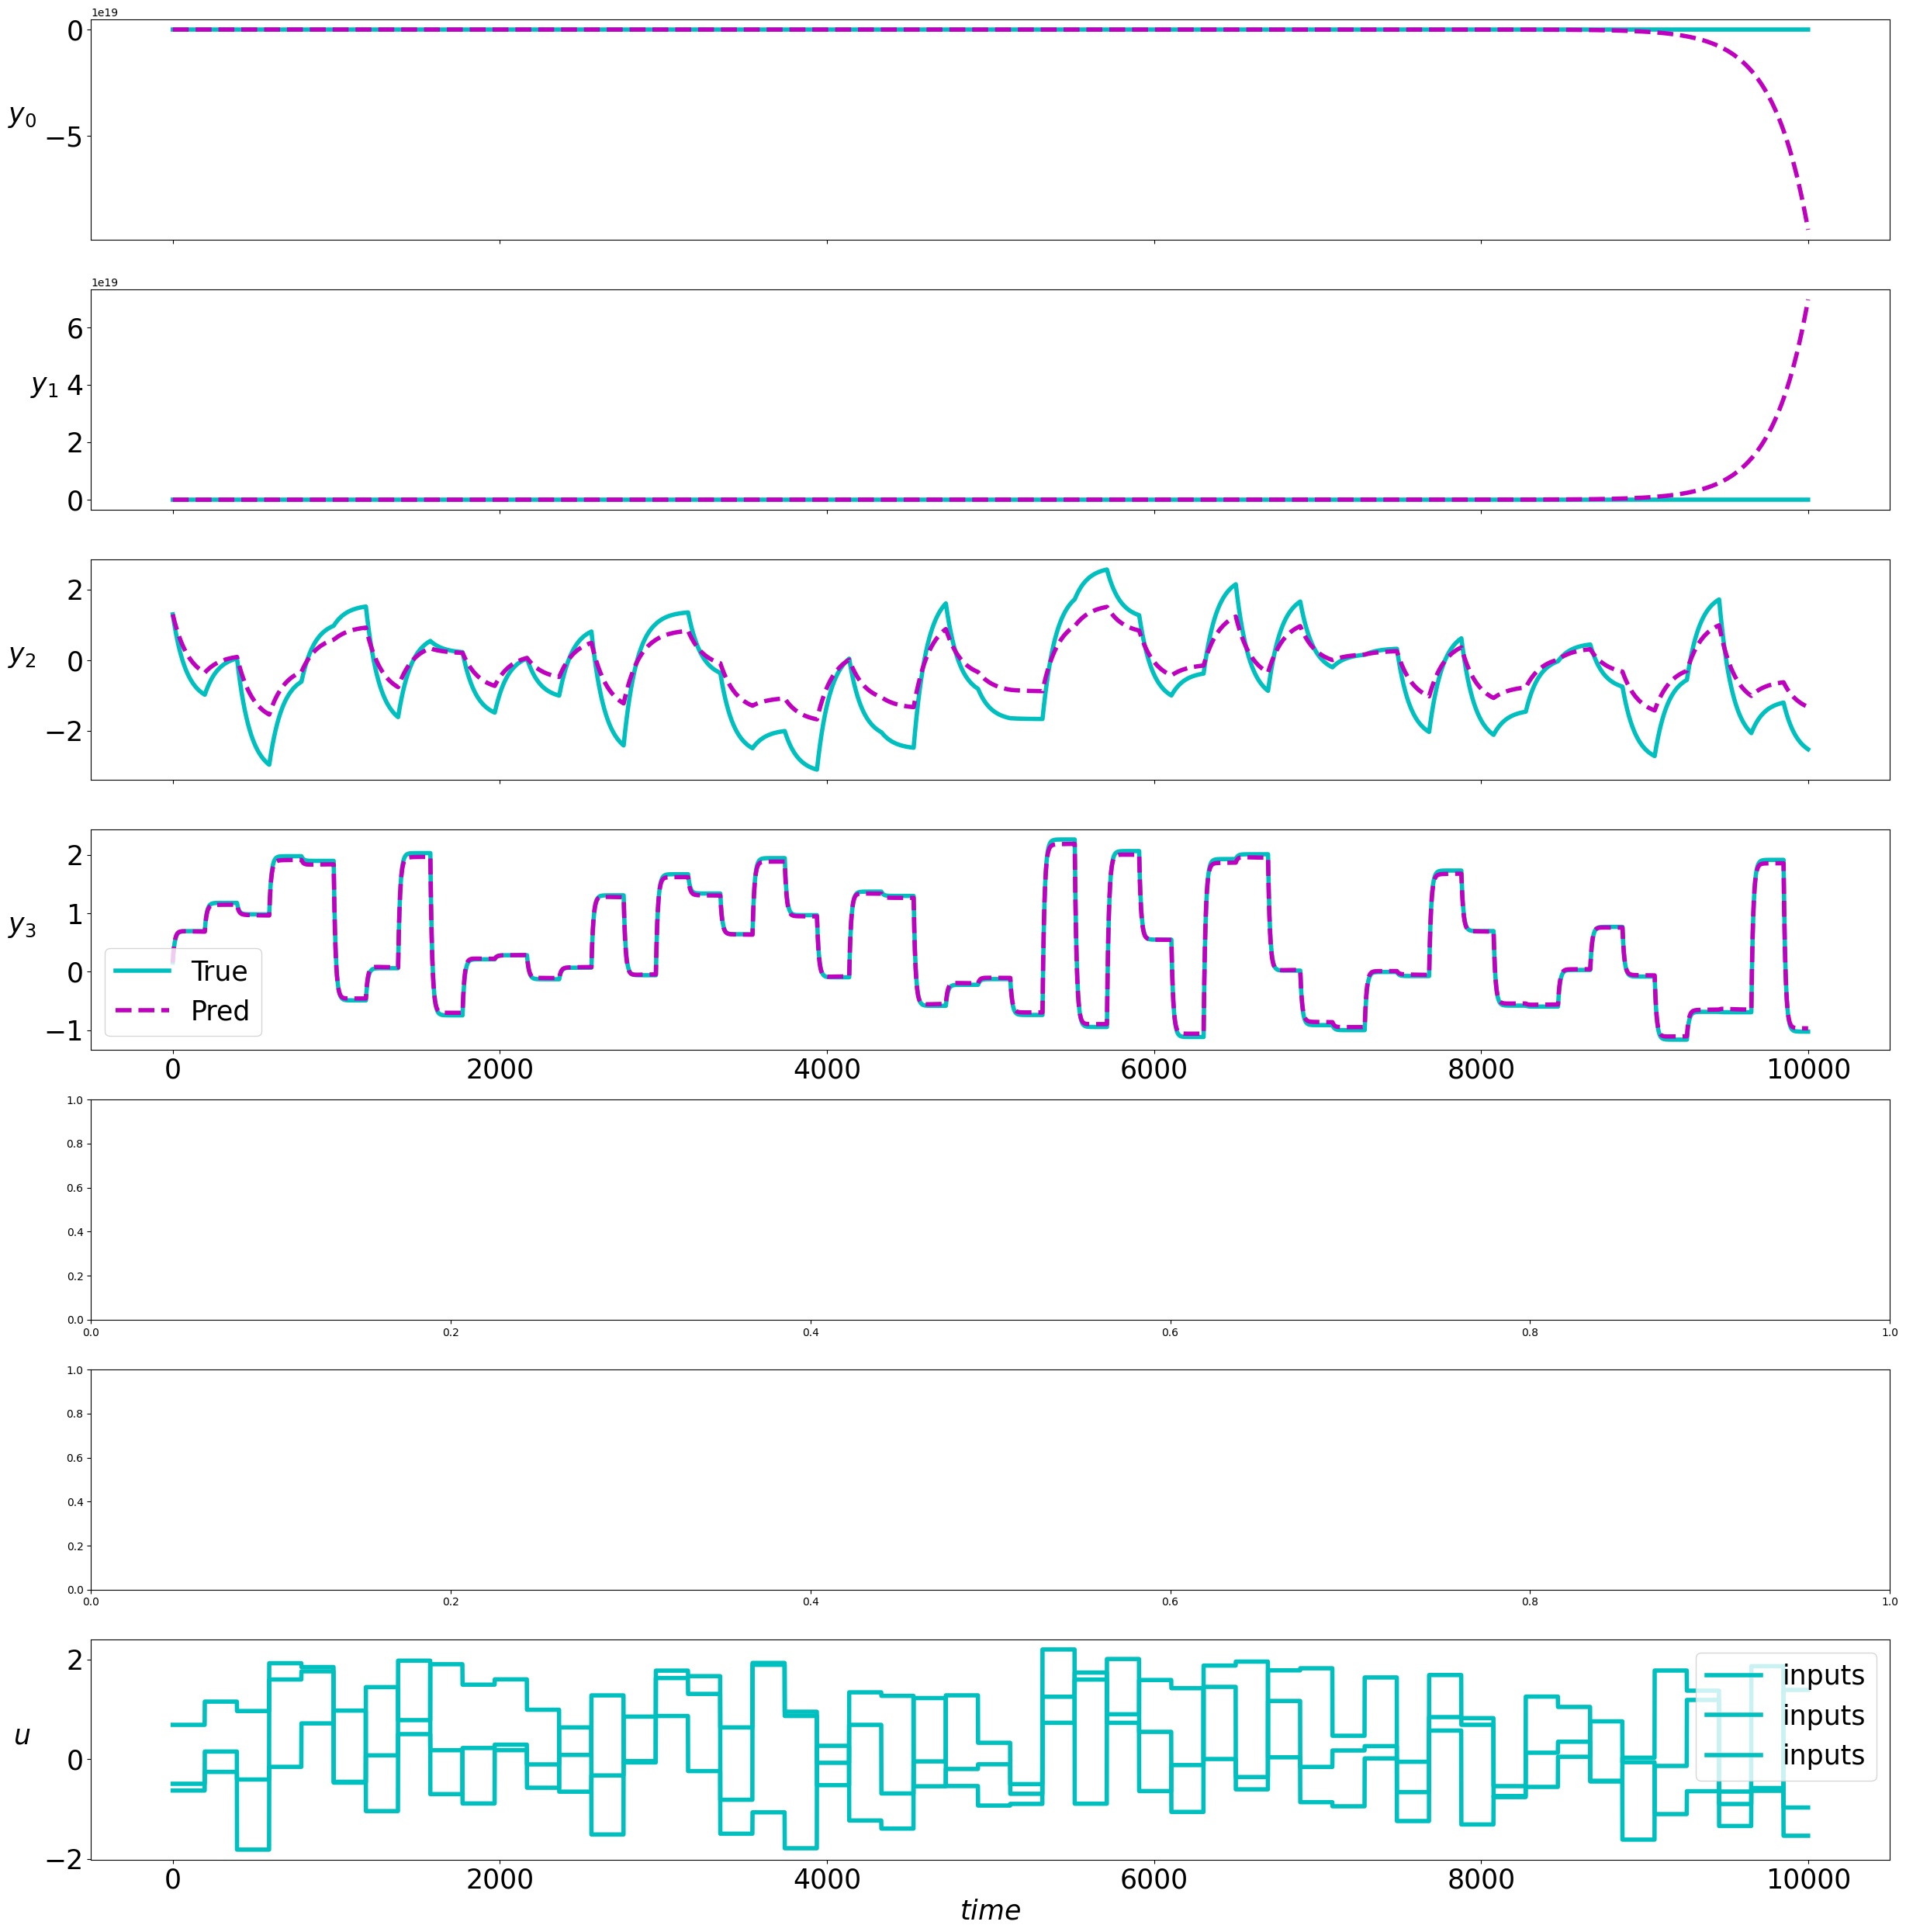

In [22]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx+nu, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))] 
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
ax[-1].plot(input_traj, 'c', linewidth=4.0, label='inputs') 
ax[-1].legend(fontsize=figsize)
ax[-1].set_xlabel('$time$', fontsize=figsize)
ax[-1].set_ylabel('$u$', rotation=0, labelpad=20, fontsize=figsize)
ax[-1].tick_params(labelbottom=True, labelsize=figsize)
plt.tight_layout()